# MSENSIS-MLE task
## Image Classification
## Papadopoulou Martha
### 10/1/2026

# Introduction 

The goal of this project was to build a model that can classify images as either cats or dogs. The dataset consists of images and a CSV file with the corresponding labels. The main steps were to preprocess the images, build a convolutional neural network, train it, and evaluate its performance.

# Implementation

### Import Libraries

In [ ]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

from PIL import Image

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

### Check Dataset Before Loading
The first thing I did was to look through the images folder, to see what kind of data I was working with. Most images are good, but there are a few problematic ones that either have a text overlaid on top, or contain only text. However, the dataset is quite large and the problematic images are a very small fraction of it, so I left them in. 

### Load Image CSV

In [2]:
df = pd.read_csv('labels.csv')

### Preprocess Features

In [3]:
# images' folder name
folder = 'images'

# initialize X, y 
X = []
y = []

# for every row in labels.cvs match the name with the images in the images folder
for idx, row in df.iterrows():

    # get image name and label
    filename = row['image_name']
    label = row['label']

    # create path for that exact file
    file_path = os.path.join(folder, filename)

    # skip hidden files
    if file_path.startswith("."):
        continue
        
    # see if the file path exists
    if os.path.isfile(file_path):

        # open images but skip corrupted files
        try:
            # load, resize and normalize the image 
            img = Image.open(file_path).convert('RGB')
            img = img.resize((60, 60))
            img = np.array(img, dtype='float32') / 255.0

            # add processed image to X and label to y
            X.append(img)
            y.append(label)
            
        except Exception as e:
            print(f'Error skipping file: {e}')

Error skipping file: cannot identify image file 'images\\667.jpg'


C:\Users\marth\anaconda3\Lib\site-packages\PIL\TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Error skipping file: cannot identify image file 'images\\18138.jpg'


Here I initialize X and y as empty lists so I can later append the image data and the corresponding labels. I iterate over the rows of the CSV file to match every entry with the image names in the folder and make a file path for each image. 

The files that start with a dot, and are hidden, are skipped. There is an if statement that checks if the file path exists, since there might be either file names in the CSV that don't exist in the folder or the other way around. If the file path doesn't exist it continues to the next row. If it exist there is a try-except block, in case there are files that can't be identified as images. As we can see above, there are two files that can't be identified and are therefore skipped (667.jpg, 18138.jpg).

There is also a warning, which means that the file is not fully intact, but still readable. Since it's only one and doesn't cause a failure, I choose to ignore the warning. 

For the images that exist both in the folder and in the CSV file, the image is loaded, resized to a much smaller resolution and converted to a numpy array. The resize to (60, 60) and the type of array set to float32 were chosen so that the memory doesn't overload, due to the large size of the dataset. At the same time the array is normalized by dividing by 255, which scales the values in X from the range [0, 255] to [0, 1].

The preprocessing of labels is left for a later step. 

### Check for Missing Files

In [4]:
# print number of labels in y and df
print(f"Number of labels in y: {len(y)}")
print(f"Number of labels in df: {len(df)}")

# initialize missing file list
missing =[] 

# iterate every file name in the df and check if it's missing from the image folder
for filename in df['image_name']:
    if not os.path.isfile(os.path.join('images', filename)):
        missing.append(filename)

print(f'Missing files: {len(missing)}')

Number of labels in y: 24288
Number of labels in df: 25000
Missing files: 710


As mentioned earlier, the code matched the image names in the CSV with the images in the folder. The next step is to check if any images are missing.

To quickly see this, I printed the length of y and the DataFrame that has the CVS data. The first is 24288 and the second is 25000. This shows that 712 are not included in the labels, and therefore in the features. 

I iterated again over the image names in the df and added any file path that didnt exist in a missing list. The length of the missing list is 710. If we also add the two files that were skipped because they couldn't be identified, we can successfully account for all 25000 files mentioned in the CSV. 

### Split Train and Test Sets

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23, stratify=y)

# convert X to numpy arrays
X_train = np.array(X_train, dtype='float32')
X_test = np.array(X_test, dtype='float32')

I split the data into training and test sets using train_test_split, with 20% of the data as testing data. However, this function returns lists, when the CNN model expects numpy arrays as input. So I convert the train and test X to numpy arrays, again as type float32, to ensure the memory usage is low.

### Preprocess Labels

In [6]:
le = LabelEncoder ()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)

I used label encoder to convert the categories [Cat, Dog] into [0, 1]. I also apply a fit_transform to y_train and transform to y_test. This is usually done to avoid data leakage, but in this case, where 0 and 1 are both in the y_train, it doesn't make a differrence. I still kept it this way to ensure a safe workflow.

### Create and Compile the CNN Model

In [7]:
# create CNN model
model = Sequential([
    Input(shape=(60, 60, 3)),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.7),
    Dense(1, activation='sigmoid')
])

# compile model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# check model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 58, 58, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 29, 29, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 27, 27, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 126,113 (492.63 KB)

 Trainable params: 126,113 (492.63 KB)

 Non-trainable params: 0 (0.00 B)

I added three convolutional layers to the model so that it can better capture the details and differences detween cats and dogs. For simpler problems like handwritten number classification, two convolutional layers are enough, but cats and dogs look more similar to each other, so I felt an extra layer was needed to capture more complex features.

The convolutional layers use 16, 32 and 64 filters. I started out with 32, 64 and 128, but the model overfitted rather quickly so I halved them. Also, the dropout layer was initially 0.5, but still the model overfitted a bit, so I tried 0.6 and 0.7. Since both gave similar results, I kept 0.7 just to be on the safe side.

The output layer has 1 neuron and a sigmoid activation, which gives as an output a probability between 0 and 1 for the binary classification

Finally, I compiled the model using the Adam optimizer, binary crossentropy as the loss function, since this is a two-class problem, and accuracy as the evaluation metric.

### CNN Model Training

In [8]:
model.fit(X_train, y_train_le, batch_size=16, epochs=10, validation_split=0.2)

Epoch 1/10
972/972 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.5291 - loss: 0.6877 - val_accuracy: 0.6387 - val_loss: 0.6262
Epoch 2/10
972/972 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.6538 - loss: 0.6281 - val_accuracy: 0.7416 - val_loss: 0.5446
Epoch 3/10
972/972 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.7292 - loss: 0.5515 - val_accuracy: 0.7506 - val_loss: 0.5167
Epoch 4/10
972/972 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.7571 - loss: 0.5071 - val_accuracy: 0.7869 - val_loss: 0.4593
Epoch 5/10
972/972 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.7847 - loss: 0.4652 - val_accuracy: 0.7815 - val_loss: 0.4660
Epoch 6/10
972/972 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.8026 - loss: 0.4429 - val_accuracy: 0.7923 - val_loss: 0.4432
Epoch 7/10
972/972 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.8193 - loss: 0.4056 - val_accuracy: 0.7712 - val_loss: 0.4724
Epoch 8/10
972/972 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.8280 - loss: 0.3876 - 

I used a batch size of 16 to avoid memory issues on my PC. 

The model trained for 10 epochs, because toward the last epochs, training accuracy and loss continued to improve, while validation accuracy stayed mostly flat and validation loss stopped decreasing. Due to these indications, I decided to stop the training here, since adding more epochs could lead to overfitting. By the last epoch, training accuracy was around 86% and validation accuracy around 82%. That is a normal gap and small enough to show that the model is learning well without overfitting.

### CNN Model Evaluation

In [9]:
test_loss, test_acc = model.evaluate(X_test, y_test_le)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')

152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8119 - loss: 0.4232
Test Loss: 0.4285
Test Accuracy: 0.8102


After training, I evaluated the model on the test set to see how it performs on unseen data. The test accuracy is around 81%, which is close to the validation accuracy during training. The test lost is also similar to the validation loss. This shows that the model generalizes well and is not overfitted.

### Make Predictions

In [10]:
y_pred_prob = model.predict(X_test, batch_size=16)

304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


### Plot ROC Curve and Compute Optimal Threshold for Predictions

Suggested threshold from ROC: 0.62
ROC curve AUC = 0.90


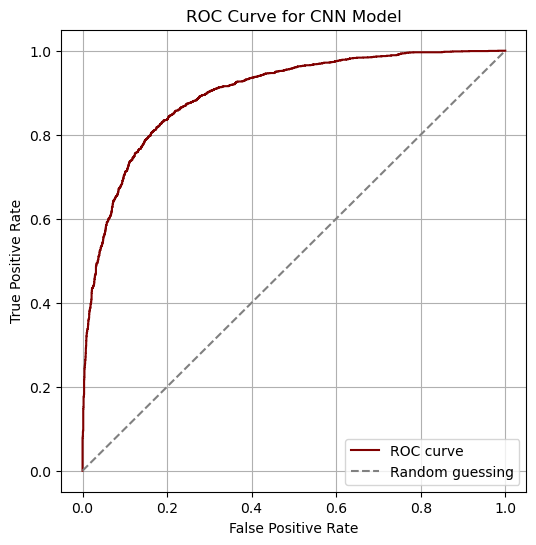

In [11]:
# calculate false positve rate, true positive rate and thresholds
fpr, tpr, thresholds = roc_curve(y_test_le, y_pred_prob)

# calculate optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f'Suggested threshold from ROC: {optimal_threshold:.2f}')

# calculate area under curve
roc_auc = auc(fpr, tpr)
print(f'ROC curve AUC = {roc_auc:.2f}')

# plot ROC curve
plt.figure(figsize=(6 ,6))
plt.plot(fpr, tpr, color='maroon', label='ROC curve')
plt.plot([0,1], [0,1], color='grey', linestyle='--', label='Random guessing')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for CNN Model')
plt.legend()
plt.grid(True)
plt.show()

To further evaluate the model and decide on a threshold for the predictions of the model, I computed the ROC curve. The area under the curve was 0.9, which suggests that the model performs well. 

To find the optimal threshold, I had to find the point where the difference between the true positive rate and the false positive rate is the largest. This gave a threshold of 0.62, which I used to convert the probability predictions into binary class labels. At first, I had tried the default threshold 0.5, but that ended up labeling more dogs as cats, so 0.62 works better.

### Convert Predictions to Binary Class Labels

In [12]:
y_pred = (y_pred_prob>optimal_threshold).astype(int).ravel()

### Visualize Confusion Matrix

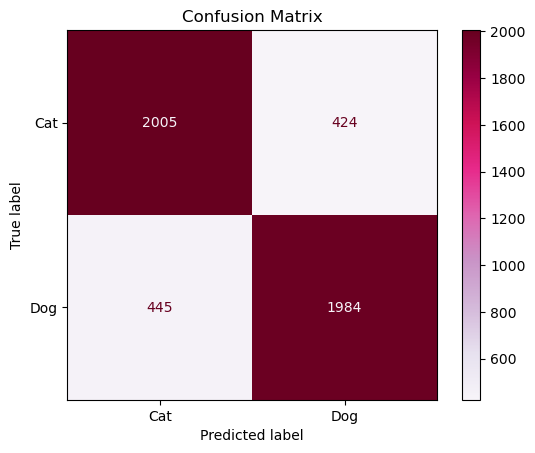

In [13]:
# calculate confusion matrix
cm = confusion_matrix(y_test_le, y_pred)

# plot confusion matrix
disp_cm = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Cat', 'Dog'])
disp_cm.plot(cmap=plt.cm.PuRd)
plt.title('Confusion Matrix')
plt.show()

Lastly, I plotted the confusion matrix to visualize how the model performs on each class. There are a few mislabeled predictions, but they are relatively low considering the size of the dataset. Using the threshold of 0.62, the model is fairly balanced between cats and dogs.

# Summary 

I loaded and preprocessed the images, encoded the labels and split the data into train and test sets.

The CNN model has three convolutional layers with 16, 32 and 64 filters, a Dense layer with 64 filters, a Dropout layer of 0.7 and a sigmoid output layer. It trained for 10 epochs and reached an accuracy of around 86% and validation accuracy around 82%. The test set, which was unseen during training, had an accuracy of around 81%. This was close to what we expected from the validation results.

The ROC curved had an AUC of 0.9, which indicated a very good model performance. The optimal threshold, that was computed from it, was 0.62 and it helped reduced the mislabeling of dogs.

The confusion matrix confirmed that with the 0.62 the model is fairly balanced between the two classes.
